# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [3]:
def calc_vif(pitch_data):
    vif_data = pd.DataFrame()
    vif_data['features'] = pitch_data.columns
    vif_data['VIF'] = [variance_inflation_factor(pitch_data.values, i) 
                       for i in range(len(pitch_data.columns))]
    return(vif_data.sort_values(by = 'VIF'))

calc_vif(pitch_data).head(23)

,features,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575
30,poor_weak%,2.339208
60,sl_hb,2.433292
64,ch%,2.848569
74,cb_hb,2.861837
56,4seam_velo_range,2.870094


In [4]:
X = pitch_data[['ev_avg', 'age', 'cu_hb', 'edge%', 
                'solid_contact%', 'poor_weak%', 
                'sl_hb', 'ch%', 'cb_hb', 
                '4seam_velo_range', '4seam%', 
                'cu%', 'cb%', '4seam_vb', 
                'sl_brk', 'sl%', 'sweet_spot%', 
                '4seam_hb', 'hard_hit%', 'ch_hb']].copy()

In [5]:
X.corr()

,ev_avg,age,cu_hb,edge%,solid_contact%,poor_weak%,sl_hb,ch%,cb_hb,4seam_velo_range,4seam%,cu%,cb%,4seam_vb,sl_brk,sl%,sweet_spot%,4seam_hb,hard_hit%,ch_hb
ev_avg,1.000000,-0.069587,-0.004080,-0.059062,0.325218,-0.556933,-0.007582,-0.143884,0.065318,0.072736,0.212799,-0.097055,0.111554,0.098341,-0.134279,-0.034487,0.195092,-0.043263,0.822068,-0.040176
age,-0.069587,1.000000,0.057584,0.048387,-0.048611,0.034850,-0.040474,-0.064548,-0.001821,-0.076501,-0.183394,0.199723,0.035654,-0.113043,0.024160,-0.062114,0.041239,0.016439,-0.071600,0.063190
cu_hb,-0.004080,0.057584,1.000000,0.001148,0.008230,-0.051883,0.287027,-0.100633,0.299013,0.002485,-0.042533,0.286031,0.084724,0.062796,0.017807,-0.116710,0.059931,-0.142879,-0.012738,-0.194854
edge%,-0.059062,0.048387,0.001148,1.000000,-0.080536,0.062829,-0.083279,0.262429,0.004973,0.000531,-0.048531,0.047404,0.007965,-0.046131,-0.099485,-0.233037,0.018690,0.070323,-0.041482,0.048788
solid_contact%,0.325218,-0.048611,0.008230,-0.080536,1.000000,-0.132950,0.046111,-0.037412,0.001294,0.117860,0.244043,-0.062415,0.045711,0.048638,-0.030131,-0.004597,0.277974,0.010901,0.358457,-0.004931
poor_weak%,-0.556933,0.034850,-0.051883,0.062829,-0.132950,1.000000,-0.080352,0.135881,-0.078270,-0.017424,-0.150844,0.044546,-0.069841,-0.066189,0.015818,-0.040978,-0.106347,0.082449,-0.287364,0.073031
sl_hb,-0.007582,-0.040474,0.287027,-0.083279,0.046111,-0.080352,1.000000,-0.104919,0.469586,-0.002808,-0.025766,0.002578,-0.098831,-0.009847,0.351709,0.196383,0.043864,-0.508792,-0.014980,-0.540869
ch%,-0.143884,-0.064548,-0.100633,0.262429,-0.037412,0.135881,-0.104919,1.000000,-0.126895,0.003893,-0.088892,-0.075690,-0.097363,-0.047818,-0.195609,-0.322347,0.084016,0.086476,-0.070121,0.009527
cb_hb,0.065318,-0.001821,0.299013,0.004973,0.001294,-0.078270,0.469586,-0.126895,1.000000,0.073722,-0.035384,0.001991,0.190093,-0.001424,0.033404,-0.021564,-0.006645,-0.568569,0.050343,-0.640258
4seam_velo_range,0.072736,-0.076501,0.002485,0.000531,0.117860,-0.017424,-0.002808,0.003893,0.073722,1.000000,0.292092,-0.095539,-0.012888,-0.481924,0.021343,0.005525,0.115930,-0.023427,0.082918,-0.027388


# Modeling

### Standardize Data

In [6]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [7]:
X_scaled[:,:] *= -1

### PCA

In [8]:
pca = PCA().fit(X_scaled)

[0.15304198 0.1321596  0.11060705 0.07955323 0.07001664 0.05899914
 0.05681429 0.04675888 0.04386329 0.03847066 0.03601336 0.03225966
 0.03139492 0.02740119 0.02155807 0.01815096 0.01739846 0.0106181
 0.00907872 0.00584177]


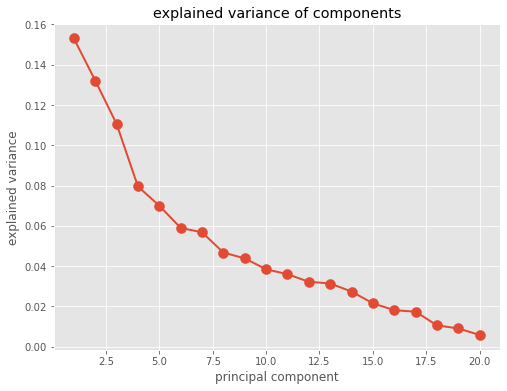

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,21), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 21), pca.explained_variance_ratio_, s = 100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');
print(pca.explained_variance_ratio_)

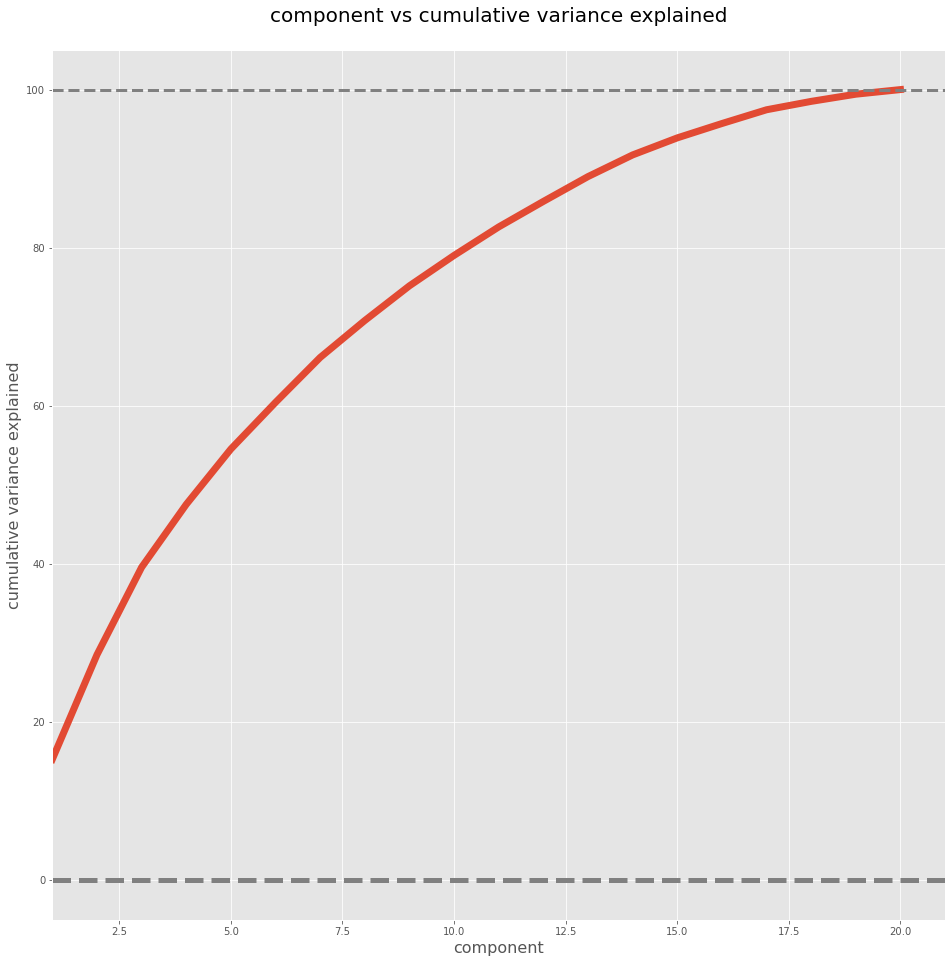

In [10]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(16,16))
component_number = range(1, 21)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,21], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [11]:
pca_component_1_eigenvec = pca.components_[0]

for weight, X in zip(pca_component_1_eigenvec, 
                     X.iloc[:,1:].columns):
    
    print(X, weight)

age 0.17233508176199297
cu_hb -0.05933607188720891
edge% 0.1793612410340889
solid_contact% -0.11182508411672325
poor_weak% 0.10089488885726873
sl_hb -0.1721378888953053
ch% 0.41594401042727036
cb_hb -0.1577383482947772
4seam_velo_range 0.41262558698580515
4seam% 0.06091031635987859
cu% 0.08542988612228228
cb% -0.10310911104385029
4seam_vb -0.022146636137649847
sl_brk 0.03093983725560417
sl% 0.15990345786817026
sweet_spot% 0.16720470783392072
4seam_hb 0.04285120437074275
hard_hit% -0.4467355525183017
ch_hb 0.14315468229355519


In [12]:
pitch_df = pd.DataFrame(data = pca.transform(X_scaled), 
                        columns = ['PC1', 'PC2', 'PC3', 'PC4', 
                                   'PC5', 'PC6', 'PC7', 'PC8', 
                                   'PC9', 'PC10', 'PC11', 'PC12', 
                                   'PC13', 'PC14', 'PC15', 'PC16', 
                                   'PC17', 'PC18', 'PC19', 'PC20'])

# ['ev_avg', 'age', 'cu_hb', 'edge%', 'solid_contact%', 'poor_weak%', 'sl_hb', 'ch%', 'cb_hb', 
# '4seam_velo_range', '4seam%', 'cu%', 'cb%', '4seam_vb', 'sl_brk', 'sl%', 'sweet_spot%', '4seam_hb', 
# 'hard_hit%', 'ch_hb']

pitch_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.635666,0.196738,4.377377,0.053537,-2.701740,-0.192291,0.502092,0.363078,1.483926,0.502267,-0.216603,-1.075497,-1.087641,-1.703659,-0.347335,-0.102120,0.134737,-0.480292,0.422648,0.022937
1,-0.678576,0.898794,0.686798,-0.877903,-0.588375,0.600089,0.676659,1.709646,1.440528,-0.125009,0.266521,-1.286391,-0.160848,0.580214,-0.323456,-0.881595,-0.248733,-0.511219,0.221959,-0.250219
2,-1.048295,-0.662729,-1.767275,0.591381,-1.594756,0.512132,1.046568,2.327064,0.235792,-0.172694,-1.314447,-0.308733,-0.955791,-0.235918,0.578252,-0.242619,-0.471292,-0.808968,-0.161325,0.132265
3,0.894550,1.470631,2.200914,-0.981528,-0.188706,0.012539,-0.061984,1.779217,0.692142,-0.379427,-1.535349,-0.093493,0.807030,0.213927,-0.118182,-1.015392,0.132382,-0.382360,-0.011881,-0.143907
4,1.334742,5.034231,2.579532,4.959760,-1.057847,3.114004,-1.752560,-0.303404,-1.188173,1.468071,-1.573505,-0.381766,-0.796266,0.267832,0.174316,0.229731,0.166839,-0.160676,-0.177911,-0.266204


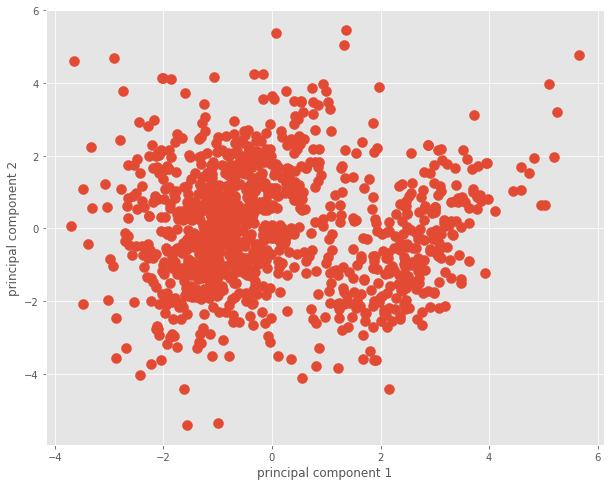

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pitch_df.iloc[:,0], pitch_df.iloc[:,1], s=100)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2');

In [14]:
# fig, ax = plt.subplots(4, 3, figsize=(10,8))

### K-Means

In [15]:
#ss = StandardScaler()
#X_scaled = ss.fit_transform()

In [16]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 21)
 
for k in K:
    km = KMeans(n_clusters=k).fit(X_scaled)
    km.fit(X_scaled)
 
    distortions.append(sum(np.min(cdist(X_scaled, km.cluster_centers_,
                                        'euclidean'), axis=1)) / X_scaled.shape[0])
    inertias.append(km.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_scaled, km.cluster_centers_,
                                   'euclidean'), axis=1)) / X_scaled.shape[0]
    mapping2[k] = km.inertia_

In [17]:
# distortion
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 4.296704992452571
2 : 3.9902307345033763
3 : 3.836241362374755
4 : 3.720851961393025
5 : 3.627107021088479
6 : 3.5605442915493426
7 : 3.497651587443803
8 : 3.447514204378582
9 : 3.401749953202586
10 : 3.36310247767281
11 : 3.3305548612781437
12 : 3.297672055567142
13 : 3.2686221491961187
14 : 3.246806054285436
15 : 3.2264423025370412
16 : 3.191566223333246
17 : 3.1857887887819856
18 : 3.161241572494938
19 : 3.132567060296968
20 : 3.1348114154250273


In [18]:
# inertia
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 21440.00000000001
2 : 18735.525360865588
3 : 17329.05321729824
4 : 16335.992015206924
5 : 15286.92640125294
6 : 14744.44133539201
7 : 14253.468922752967
8 : 13826.777304316503
9 : 13479.249516048854
10 : 13116.910157802895
11 : 12930.606630680762
12 : 12660.44070987874
13 : 12392.55593888203
14 : 12215.713442077438
15 : 12085.365221832744
16 : 11852.948138407684
17 : 11729.697145378559
18 : 11565.586411427847
19 : 11385.143784551476
20 : 11328.437925925153


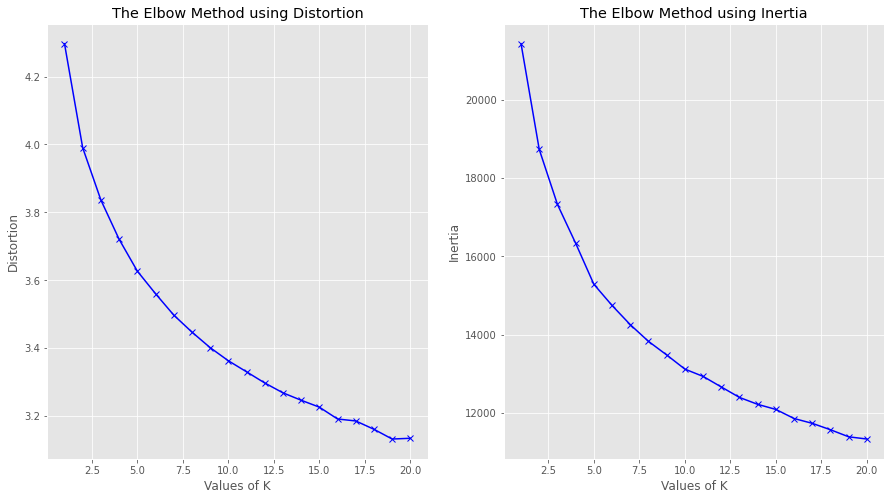

In [19]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

fig, ax = plt.subplots(1, 2, figsize = (15,8))
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[0].set_title('The Elbow Method using Distortion')

ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia')
ax[1].set_title('The Elbow Method using Inertia');

In [20]:
km = KMeans(n_clusters = 5,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[0 1 3 ... 2 1 1]


In [21]:
pitch_df['label'] = label
pitch_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,label
0,-0.635666,0.196738,4.377377,0.053537,-2.701740,-0.192291,0.502092,0.363078,1.483926,0.502267,...,-1.075497,-1.087641,-1.703659,-0.347335,-0.102120,0.134737,-0.480292,0.422648,0.022937,0
1,-0.678576,0.898794,0.686798,-0.877903,-0.588375,0.600089,0.676659,1.709646,1.440528,-0.125009,...,-1.286391,-0.160848,0.580214,-0.323456,-0.881595,-0.248733,-0.511219,0.221959,-0.250219,1
2,-1.048295,-0.662729,-1.767275,0.591381,-1.594756,0.512132,1.046568,2.327064,0.235792,-0.172694,...,-0.308733,-0.955791,-0.235918,0.578252,-0.242619,-0.471292,-0.808968,-0.161325,0.132265,3
3,0.894550,1.470631,2.200914,-0.981528,-0.188706,0.012539,-0.061984,1.779217,0.692142,-0.379427,...,-0.093493,0.807030,0.213927,-0.118182,-1.015392,0.132382,-0.382360,-0.011881,-0.143907,0
4,1.334742,5.034231,2.579532,4.959760,-1.057847,3.114004,-1.752560,-0.303404,-1.188173,1.468071,...,-0.381766,-0.796266,0.267832,0.174316,0.229731,0.166839,-0.160676,-0.177911,-0.266204,4


In [22]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [0 1 3 ... 2 1 1]
Number of iterations: 22
Number of features: 20
Number of clusters: 5
Inertia: 15289.386568336755
Silhouette Score: 0.15334361573151004


In [23]:
a = np.array([[2, 4, 6, 8], [10, 20, 30, 40], [1, 3, 5, 7], [10, 12, 14, 16], [11, 13, 15, 17]])
print(a, '\n')
b = a[:5, 0:3:2]    #[rows, columns]
print(b, '\n')
c = a[:5, 1:4:2]
print(c)

[[ 2  4  6  8]
 [10 20 30 40]
 [ 1  3  5  7]
 [10 12 14 16]
 [11 13 15 17]] 

[[ 2  6]
 [10 30]
 [ 1  5]
 [10 14]
 [11 15]] 

[[ 4  8]
 [20 40]
 [ 3  7]
 [12 16]
 [13 17]]


In [24]:
centroids = km.cluster_centers_

print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')
print(centroids)

Predicted clusters to points:  [0 1 3 0 4 2 0 2 3 1] 

Location of centroids: 

[[-2.23285010e-01  3.08794584e-02  2.18597983e+00 -3.09131537e-01
  -2.11937130e-01 -3.55514364e-01 -2.54107600e-01 -1.26486170e-02
  -1.12117412e-01 -1.04929380e-01 -2.53379485e-01 -1.30954295e-02
  -1.35130767e-01 -2.45468247e-01 -1.79896438e-02 -8.92676733e-03
   1.95720470e-01  1.70547348e-02 -7.87409600e-03 -1.68813675e-02]
 [-9.77097836e-01  1.48789698e+00 -5.32850064e-01 -2.28678953e-01
  -3.05271353e-02  2.05267183e-02  8.53645826e-02  3.02251411e-02
   4.02801580e-02 -5.65357479e-02  6.25327244e-02 -4.59335354e-03
   2.51838473e-02  5.55434546e-02  8.33115826e-02  9.13325183e-02
  -1.39186678e-01  8.47648566e-03  1.34504406e-04  7.76839442e-04]
 [ 2.50662094e+00 -5.61884247e-01 -6.45392858e-01 -2.04405096e-01
  -3.88196034e-01  4.84352423e-02 -2.94385824e-02 -1.95720136e-01
   3.63673114e-02  5.66134771e-02  1.98670233e-01 -7.76641802e-02
   2.47137158e-02  4.05654068e-02 -7.25869209e-02 -7.2706899

In [25]:
centroids_x = centroids[:5, 0:3:2]
print('x', centroids_x)
centroids_y = centroids[:5, 1:4:2]
print('y', centroids_y)

x [[-0.22328501  2.18597983]
 [-0.97709784 -0.53285006]
 [ 2.50662094 -0.64539286]
 [-1.31730398 -0.38535551]
 [ 1.05824156  0.86063458]]
y [[ 0.03087946 -0.30913154]
 [ 1.48789698 -0.22867895]
 [-0.56188425 -0.2044051 ]
 [-1.26267447 -0.06426078]
 [ 1.05766065  4.08391176]]


In [26]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3,4
PC1,-0.223285,-0.977098,2.506621,-1.317304,1.058242
PC2,0.030879,1.487897,-0.561884,-1.262674,1.057661
PC3,2.185980,-0.532850,-0.645393,-0.385356,0.860635
PC4,-0.309132,-0.228679,-0.204405,-0.064261,4.083912
PC5,-0.211937,-0.030527,-0.388196,0.181204,2.036214
PC6,-0.355514,0.020527,0.048435,0.044808,0.685679
PC7,-0.254108,0.085365,-0.029439,0.024267,0.442170
PC8,-0.012649,0.030225,-0.195720,0.115441,0.244798
PC9,-0.112117,0.040280,0.036367,0.000096,-0.027283
PC10,-0.104929,-0.056536,0.056613,0.014183,0.357860


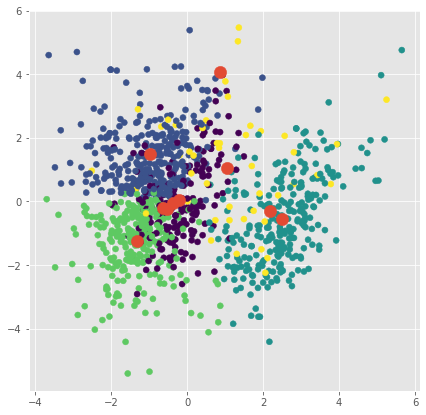

In [27]:
plt.figure(figsize=(7,7))

plt.scatter(pitch_df['PC1'], pitch_df['PC2'], 
            c=pitch_df['label']);
plt.scatter(centroids[:, 0:3:2], 
            centroids[:, 1:4:2], 
            marker='o', s=150);

In [28]:
#pitch_df = pitch_df.values

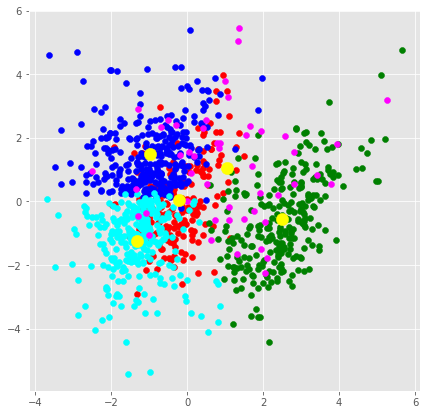

In [29]:
pitch_df = pitch_df.values
plt.figure(figsize=(7,7))
plt.scatter(pitch_df[label==0, 0], pitch_df[label==0, 1], c='red', label ='Cluster 1')
plt.scatter(pitch_df[label==1, 0], pitch_df[label==1, 1], c='blue', label ='Cluster 2')
plt.scatter(pitch_df[label==2, 0], pitch_df[label==2, 1], c='green', label ='Cluster 3')
plt.scatter(pitch_df[label==3, 0], pitch_df[label==3, 1], c='cyan', label ='Cluster 4')
plt.scatter(pitch_df[label==4, 0], pitch_df[label==4, 1], c='magenta', label ='Cluster 5')
plt.scatter(centroids[:, 0], centroids[:, 1], s=150, c='yellow', label = 'Centroids');